In [ ]:
import requests
import json
from datetime import datetime

def get_latest_f1_results():
    """
    Fetches the latest F1 race results using the OpenF1 API
    Returns a dictionary with driver numbers as keys and finish positions as values
    """
    
    try:
        # Get the latest race session
        sessions_url = "https://api.openf1.org/v1/sessions"
        params = {
            'session_type': 'Race',
            'year': 2024  # Adjust year as needed
        }
        
        sessions_response = requests.get(sessions_url, params=params)
        sessions_response.raise_for_status()
        sessions = sessions_response.json()
        
        if not sessions:
            print("No race sessions found")
            return {}
        
        # Get the most recent race session
        latest_session = max(sessions, key=lambda x: x['date_start'])
        session_key = latest_session['session_key']
        
        print(f"Latest race: {latest_session['meeting_name']} - {latest_session['session_name']}")
        print(f"Date: {latest_session['date_start'][:10]}")
        print(f"Session Key: {session_key}")
        
        # Get final positions for the race using the position endpoint
        # We need to get the last recorded position for each driver
        position_url = "https://api.openf1.org/v1/position"
        position_params = {
            'session_key': session_key
        }
        
        position_response = requests.get(position_url, params=position_params)
        position_response.raise_for_status()
        positions = position_response.json()
        
        if not positions:
            print("No position data found for the latest session")
            return {}
        
        # Group positions by driver and get their final position
        driver_final_positions = {}
        
        # Sort positions by date to get the latest position for each driver
        positions.sort(key=lambda x: x['date'])
        
        # Get the final position for each driver (their last recorded position)
        for position in positions:
            driver_number = position.get('driver_number')
            final_position = position.get('position')
            
            if driver_number is not None and final_position is not None:
                # Keep updating with the latest position for each driver
                driver_final_positions[driver_number] = [final_position]
        
        return driver_final_positions
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}
    except KeyError as e:
        print(f"Missing expected field in response: {e}")
        print("Available fields in session:", list(sessions[0].keys()) if sessions else "No sessions")
        return {}
    except Exception as e:
        print(f"Unexpected error: {e}")
        return {}

def get_latest_session_key():
    """
    Alternative method to get the latest session key directly
    """
    try:
        # Try using 'latest' parameter if supported
        sessions_url = "https://api.openf1.org/v1/sessions"
        params = {
            'session_key': 'latest'
        }
        
        response = requests.get(sessions_url, params=params)
        if response.status_code == 200:
            sessions = response.json()
            if sessions:
                return sessions[0]['session_key']
    except:
        pass
    
    return None

def main():
    """Main function to run the script"""
    print("Fetching latest F1 race results...")
    
    # First try the main method
    results = get_latest_f1_results()

    driver_names = {}
    
    # If that fails, try using the latest session key directly
    if not results:
        print("\nTrying alternative method with latest session...")
        latest_key = get_latest_session_key()
        if latest_key:
            print(f"Found latest session key: {latest_key}")
            # Try to get positions for this session
            try:
                position_url = "https://api.openf1.org/v1/position"
                drivers_url = "https://api.openf1.org/v1/drivers"
                response = requests.get(position_url, params={'session_key': latest_key})
                if response.status_code == 200:
                    positions = response.json()
                    if positions:
                        # Process positions the same way
                        driver_final_positions = {}
                        positions.sort(key=lambda x: x['date'])
                        
                        for position in positions:
                            driver_number = position.get('driver_number')
#                            driver_name = requests.get(drivers_url, params={'driver_number': driver_number}).json().get('name_acronym')
                            final_position = position.get('position')
                            
                            if driver_number is not None and final_position is not None:
                                driver_final_positions[driver_number] = [final_position]
#                            if driver_name is not None:
#                                driver_names[driver_number] = driver_name
                        
                        results = driver_final_positions
            except Exception as e:
                print(f"Alternative method failed: {e}")
    
    if results:
        print("\nLatest F1 Race Results:")
        print("Driver Number : XXX : Finish Position")
        print("-" * 35)
        
        # Sort by finish position for better readability
        sorted_results = dict(sorted(results.items(), key=lambda x: x[1][0]))
        
        for driver_num, position in sorted_results.items():
            # Fetch driver name if available
            try:
                driver_response = requests.get(f"https://api.openf1.org/v1/drivers?driver_number={driver_num}&session_key={latest_key}")
                if driver_response.status_code == 200:
                    driver_data = driver_response.json()
                    driver_name = driver_data[0].get('name_acronym', 'nown Driver')
                    driver_names[driver_num] = driver_name
                else:
                    driver_names[driver_num] = ''
            except Exception as e:
                print(f"Error fetching driver name for {driver_num}: {e}")
                driver_names[driver_num] = 'UNK'
            print(f"Driver {driver_num:2d}     : {driver_names[driver_num]} : {position[0]}")
        
        print(f"\nResults as dictionary:")
        print(results)
    else:
        print("No results to display")
        print("\nDebugging: Let's check what sessions are available...")
        
        # Debug: Show available sessions
        try:
            sessions_response = requests.get("https://api.openf1.org/v1/sessions?year=2024")
            if sessions_response.status_code == 200:
                sessions = sessions_response.json()
                print(f"Found {len(sessions)} sessions for 2024")
                if sessions:
                    print("Latest 3 sessions:")
                    # Sort by date and show latest 3
                    sessions.sort(key=lambda x: x['date_start'], reverse=True)
                    for i, session in enumerate(sessions[:3]):
                        print(f"  {i+1}. {session.get('country_name', 'Unknown')} - {session.get('session_name', 'Unknown')} ({session.get('date_start', 'Unknown')[:10]})")
        except Exception as e:
            print(f"Debug query failed: {e}")



In [174]:
driver_num = 50

try:
    driver_response = requests.get(f"https://api.openf1.org/v1/drivers?driver_number={driver_num}")
    if driver_response.status_code == 200:
        print(driver_response.headers['content-type'])
        driver_data = driver_response.json()
        driver_name = driver_data[0].get('name_acronym', 'Unknown Driver')
        driver_names = driver_name
    else:
        driver_names = 'UNK'
except Exception as e:
    print(f"Error fetching driver name for {driver_num}: {e}")
    driver_names = 'UNK'

print(f"Driver {driver_num:2d}     : {driver_names} ")

application/json
Driver 50     : BEA 


In [6]:
import requests

driver_response = requests.get(f"https://api.openf1.org/v1/drivers?driver_number={4}")

print(driver_response.text)

[{"meeting_key":1140,"session_key":7763,"driver_number":4,"broadcast_name":"L NORRIS","full_name":"Lando NORRIS","name_acronym":"NOR","team_name":"McLaren","team_colour":"F58020","first_name":"Lando","last_name":"Norris","headshot_url":"https://www.formula1.com/content/dam/fom-website/drivers/L/LANNOR01_Lando_Norris/lannor01.png.transform/1col/image.png","country_code":"GBR"},{"meeting_key":1140,"session_key":7764,"driver_number":4,"broadcast_name":"L NORRIS","full_name":"Lando NORRIS","name_acronym":"NOR","team_name":"McLaren","team_colour":"F58020","first_name":"Lando","last_name":"Norris","headshot_url":"https://www.formula1.com/content/dam/fom-website/drivers/L/LANNOR01_Lando_Norris/lannor01.png.transform/1col/image.png","country_code":"GBR"},{"meeting_key":1140,"session_key":9222,"driver_number":4,"broadcast_name":"L NORRIS","full_name":"Lando NORRIS","name_acronym":"NOR","team_name":"McLaren","team_colour":"F58020","first_name":"Lando","last_name":"Norris","headshot_url":"https:/

In [7]:
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# F1 Points system
RACE_POINTS = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}

SPRINT_POINTS = {
    1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1
}

def get_all_season_results(year=2025, debug=False):
    """
    Fetches all F1 race and sprint results for the specified season
    Returns three dictionaries:
    1. driver_positions: {driver_number: [list of positions]}
    2. driver_points: {driver_number: total_points}
    3. driver_names: {driver_number: name_acronym}
    """
    
    driver_positions = {}
    driver_points = {}
    driver_names = {}
    driver_teams = {}
    driver_colors = {}
    driver_history = {}
    session_names = []
    sessionCounter = 0
    
    try:
        print(f"Fetching all sessions for {year}...")
        
        # Get all sessions for the year
        sessions_url = "https://api.openf1.org/v1/sessions"
        params = {'year': year}
        
        sessions_response = requests.get(sessions_url, params=params)
        sessions_response.raise_for_status()
        sessions = sessions_response.json()
        
        if not sessions:
            print(f"No sessions found for {year}")
            return driver_positions, driver_points, driver_names
        
        # Filter for Race and Sprint sessions only
        race_sessions = [s for s in sessions if s.get('session_type') in ['Race'] and 
                        s.get('session_name') in ['Race', 'Sprint']]
        
        print(f"Found {len(race_sessions)} race/sprint sessions")
        
        # Sort sessions by date
        race_sessions.sort(key=lambda x: x['date_start'])
        
        for session in race_sessions:
            session_key = session['session_key']
            session_name = session.get('session_name', 'Unknown')
            meeting_name = session.get('country_name', 'Unknown')
            is_sprint = session_name == 'Sprint'
            
            session_names.append(meeting_name if not is_sprint else meeting_name + " Sprint")
            
            if debug:
                print(f"\nDebug: Processing session {session_key} - {meeting_name} - {session_name}")
            
            # Get driver names for this session (if we don't have them yet)
            if not driver_names:
                drivers_response = requests.get(
                    "https://api.openf1.org/v1/drivers",
                    params={'session_key': session_key}
                )
                if drivers_response.status_code == 200:
                    drivers_data = drivers_response.json()
                    for driver in drivers_data:
                        driver_num = driver.get('driver_number')
                        name_acronym = driver.get('name_acronym')
                        team_name = driver.get('team_name', 'Unknown Team')
                        color = driver.get('team_colour', '#777777')  # Default to grey if no color provided
                        if driver_num and name_acronym:
                            driver_names[driver_num] = name_acronym
                        if driver_num and team_name:
                            driver_teams[driver_num] = team_name
                        if driver_num and color:
                            driver_colors[driver_num] = color
            
            # Get positions for this session
            position_response = requests.get(
                "https://api.openf1.org/v1/position",
                params={'session_key': session_key}
            )
            
            if position_response.status_code == 200:
                positions = position_response.json()
                if positions:
                    # Get final positions for each driver
                    final_positions = get_final_positions(positions)
                    

                    # Process results
                    for driver_num, position in final_positions.items():
                        # Initialize driver data if not exists
                        if driver_num not in driver_positions:
                            driver_positions[driver_num] = [None] * sessionCounter
                            driver_points[driver_num] = 0
                            driver_history[driver_num] = [0] * sessionCounter
                        

                        
                        # Add position to driver's list
                        driver_positions[driver_num].append(position)
                        
                        # Calculate and add points
                        points_table = SPRINT_POINTS if is_sprint else RACE_POINTS
                        points = points_table.get(position, 0)
                        driver_points[driver_num] += points
                        driver_history[driver_num].append(driver_points[driver_num])
                        
                        if debug:
                            print(f"  Driver {driver_num}: P{position} ({points} pts)")

                    for driver_num in driver_positions:
                        if driver_num not in final_positions:
                            # If driver has no position in this session, we can assume they didn't participate
                            driver_positions[driver_num].append(None)
                            driver_history[driver_num].append(driver_points[driver_num])

                else:
                    print(f"  No position data found")
            else:
                print(f"  Failed to get position data (status: {position_response.status_code})")
            
            sessionCounter += 1
        
        # Fill in driver names for any remaining drivers
        fill_missing_driver_names(driver_names, driver_teams, driver_colors, driver_positions.keys(), year)
        
        return driver_positions, driver_points, driver_names, driver_teams, driver_colors, driver_history, session_names, sessionCounter
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return driver_positions, driver_points, driver_names, driver_teams, driver_colors, driver_history, session_names, sessionCounter
    except Exception as e:
        print(f"Unexpected error: {e}")
        return driver_positions, driver_points, driver_names, driver_teams, driver_colors, driver_history, session_names, sessionCounter

def get_final_positions(positions):
    """
    Process position data to get final positions for each driver
    """
    if not positions:
        return {}
    
    # Sort positions by date to get chronological order
    positions.sort(key=lambda x: x['date'])
    
    # Get the final position for each driver (their last recorded position)
    final_positions = {}
    for position in positions:
        driver_number = position.get('driver_number')
        final_position = position.get('position')
        
        if driver_number is not None and final_position is not None:
            final_positions[driver_number] = final_position
    
    return final_positions

def fill_missing_driver_names(driver_names, driver_teams, driver_colors, driver_numbers, year):
    """
    Try to fill in missing driver names by querying different sessions
    """
    missing_drivers = [num for num in driver_numbers if num not in driver_names]
    
    if not missing_drivers:
        return
    
    print(f"\nTrying to find names for {len(missing_drivers)} drivers({missing_drivers})...")
    
    try:
        # Get a few random sessions to try to find driver names
        sessions_response = requests.get(
            "https://api.openf1.org/v1/sessions",
            params={'year': year}
        )
        
        if sessions_response.status_code == 200:
            sessions = sessions_response.json()
            # Try first few sessions
            for session in sessions[:5]:
                if not missing_drivers:
                    break
                    
                drivers_response = requests.get(
                    "https://api.openf1.org/v1/drivers",
                    params={'session_key': session['session_key']}
                )
                
                if drivers_response.status_code == 200:
                    drivers_data = drivers_response.json()
                    for driver in drivers_data:
                        driver_num = driver.get('driver_number')
                        name_acronym = driver.get('name_acronym')
                        if driver_num in missing_drivers and name_acronym:
                            driver_names[driver_num] = name_acronym
                            missing_drivers.remove(driver_num)
    except Exception as e:
        print(f"Error filling driver names with method 1: {e}")
    
    if missing_drivers:
        print(f"\nTrying to find names for remaining {len(missing_drivers)} drivers with method 2...")
        for driver_num in missing_drivers:
            try:
                driver_response = requests.get(f"https://api.openf1.org/v1/drivers?driver_number={driver_num}")
                if driver_response.status_code == 200:
                    driver_data = driver_response.json()
                    name_acronym = driver_data[0].get('name_acronym', 'Unknown Driver')

                    team_name = driver_data[0].get('team_name', 'Unknown Team')
                    color = driver_data[0].get('team_colour', '777777')  #

                    driver_names[driver_num] = name_acronym
                    if team_name:
                        driver_teams[driver_num] = team_name
                    if color:
                        driver_colors[driver_num] = color
                    missing_drivers.remove(driver_num)
            except Exception as e:
                print(f"Error fetching driver name for {driver_num}: {e}")
                driver_names[driver_num] = 'UNK'
    
                        


def print_summary(complete_standings, driver_positions, sessionCounter):
    """
    Print a nice summary of the season results
    """
    print("\n" + "="*60)
    print("SEASON SUMMARY")
    print("="*60)
    
    # Championship standings (sorted by points)
    print("\nCHAMPIONSHIP STANDINGS:")
    print("-" * 40)
    
    
    for i, (driver_num, points, driver_name, driver_team, _) in enumerate(complete_standings, 1):
        races_completed = len(driver_positions.get(driver_num, []))
        avg_position = sum(driver_positions.get(driver_num, [])) / races_completed if races_completed > 0 else 0
        
        print(f"{i:2d}. {driver_num:2d} - {driver_name:3s} - {points:3d} pts ({driver_team}, {races_completed} races, avg: {avg_position:.1f})")
    
    print(f"\nTOTAL RACES/SPRINTS PROCESSED: {sessionCounter}")


def main(year = 2025, summary_printout=False, verbose=False, compact=False):
    """Main function to run the script"""
#    year = 2025  # Change this to get different seasons
    
    print(f"Fetching complete F1 {year} season results...")
    print("This includes both regular races and sprint races")
    print("-" * 50)
    
    # Get all season data
    driver_positions, driver_points, driver_names, driver_teams, driver_colors, driver_history, session_names, sessionCounter = get_all_season_results(year)
    
    if not driver_positions:
        print("No results found. This could be because:")
        print("1. No race data available for the specified year")
        print("2. API connection issues")
        print("3. The season hasn't started yet")
        print("Exiting...")
        quit()

    standings = sorted(driver_points.items(), key=lambda x: x[1], reverse=True)

    complete_standings = [ (driver_num, points, driver_names.get(driver_num, 'UNK'), driver_teams.get(driver_num, 'Unknown Team'), driver_colors.get(driver_num, '777777')) for driver_num, points in standings ]

    # Print summary
    if summary_printout:
        print_summary(complete_standings, driver_positions, sessionCounter)
    
    # Print the dictionaries as requested
    if verbose:
        print(f"\n" + "="*60)
        print("REQUESTED DICTIONARIES:")
        print("="*60)
        
        print(f"\n1. DRIVER POSITIONS (driver_number: [list of positions]):")
        print("-" * 55)
        for driver_num in sorted(driver_positions.keys()):
            positions = driver_positions[driver_num]
            name = driver_names.get(driver_num, f"UNK")
            print(f"Driver {driver_num:2d} ({name}): {positions}")
        
        print(f"\n2. DRIVER POINTS (driver_number: total_points):")
        print("-" * 45)
        for driver_num in sorted(driver_points.keys()):
            points = driver_points[driver_num]
            name = driver_names.get(driver_num, f"UNK")
            print(f"Driver {driver_num:2d} ({name}): {points} points")
        
        print(f"\n3. DRIVER NAMES (driver_number: name_acronym):")
        print("-" * 45)
        for driver_num in sorted(driver_names.keys()):
            name = driver_names[driver_num]
            print(f"Driver {driver_num:2d}: '{name}'")
    
    if compact:
        print(f"\n" + "-"*60)
        print("Raw dictionaries for easy copying:")
        print("-"*60)
        print(f"\ndriver_positions = {driver_positions}")
        print(f"\ndriver_points = {driver_points}")
        print(f"\ndriver_names = {driver_names}")

    print("1" if all(len(i) == sessionCounter for i in driver_positions.values()) else "0")
#    print(''.join("1" if len))
    print(driver_positions)
    print(driver_history)




    plt.figure(figsize=(12, 6))
    plt_pts = [ points for _, points, _, _, _ in complete_standings ]
    plt_names = [ name+'\n'+str(num) for num, _, name, _, _ in complete_standings ]
    plt_clrs = [ '#'+color for _, _, _, _, color in complete_standings ]
    plt.bar(plt_names, plt_pts, color=plt_clrs)
    plt.hlines(plt_pts[0]-25, 0, plt_names[-1], colors='black', linestyles='--')
    plt.xlabel('Drivers')
    plt.ylabel('Points')
    plt.title(f'F1 {year} Season Points Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(linestyle='-.', which='both')
    plt.show()


    plt.figure(figsize=(12, 6))
    for key, values in driver_history.items():
        label = driver_names.get(key, f"Driver {key}")
        color = '#' + driver_colors.get(key, '777777')
        plt.plot(session_names, values, label=label, marker='o', color=color)
        
        # Place label near the last point
        plt.text(session_names[-1], values[-1], f' {label}', va='center', ha='left', color=color, fontsize=10)
#    for key, values in driver_history.items():
#        plt.plot(session_names, values, label=driver_names.get(key, f"Driver {key}"), marker='o', color='#'+driver_colors.get(key, '777777'))
    plt.xticks(rotation=45)
    plt.title(f'F1 {year} Season Points History')
#    plt.xticks(np.arange(len(session_names)), session_names, rotation=45)
    plt.tight_layout()
    plt.xlabel("Session")
    plt.ylabel("Points")
    plt.grid(linestyle='-.', which='both')
    plt.show()


def plotting(year = 2025):

    driver_positions, driver_points, driver_names, driver_teams, driver_colors, driver_history, session_names, sessionCounter = get_all_season_results(year)

    standings = sorted(driver_points.items(), key=lambda x: x[1], reverse=True)

    complete_standings = [ (driver_num, points, driver_names.get(driver_num, 'UNK'), driver_teams.get(driver_num, 'Unknown Team'), driver_colors.get(driver_num, '777777')) for driver_num, points in standings ]

    plt.figure(figsize=(12, 6))
    plt_pts = [ points for _, points, _, _, _ in complete_standings ]
    plt_names = [ name+'\n'+str(num) for num, _, name, _, _ in complete_standings ]
    plt_clrs = [ '#'+color for _, _, _, _, color in complete_standings ]
    plt.bar(plt_names, plt_pts, color=plt_clrs)
    plt.hlines(plt_pts[0]-25, 0, plt_names[-1], colors='black', linestyles='--')
    plt.xlabel('Drivers')
    plt.ylabel('Points')
    plt.title(f'F1 {year} Season Points Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(linestyle='-.', which='both')
    plt.show()


    plt.figure(figsize=(12, 6))
    for key, values in driver_history.items():
        label = driver_names.get(key, f"Driver {key}")
        color = '#' + driver_colors.get(key, '777777')
        plt.plot(session_names, values, label=label, marker='o', color=color)
        
        # Place label near the last point
        plt.text(session_names[-1], values[-1], f' {label}', va='center', ha='left', color=color, fontsize=10)
    plt.xticks(rotation=45)
    plt.title(f'F1 {year} Season Points History')
    plt.tight_layout()
    plt.xlabel("Session")
    plt.ylabel("Points")
    plt.grid(linestyle='-.', which='both')
    plt.show()


Fetching complete F1 2025 season results...
This includes both regular races and sprint races
--------------------------------------------------
Fetching all sessions for 2025...
Found 14 race/sprint sessions

Trying to find names for 1 drivers([43])...

Trying to find names for remaining 1 drivers with method 2...
1
{1: [2, 3, 4, 1, 6, 2, 17, 4, 1, 4, 10, 2, 18, 5], 4: [1, 8, 2, 2, 3, 4, 1, 2, 2, 1, 2, 18, 1, 1], 5: [16, 18, 17, 19, 19, 18, 15, 18, 18, 14, 12, 14, 8, 18], 6: [19, 13, 14, 8, 14, 10, 13, 11, 9, 6, 7, 16, 12, 17], 7: [20, 20, 16, 15, 15, 17, 16, 20, None, None, None, None, None, None], 10: [11, 12, 11, 13, 7, 20, 11, 13, 13, 20, 8, 15, 13, 6], 12: [5, 7, 8, 6, 11, 6, 10, 6, 19, 18, 18, 3, 19, 16], 14: [17, 10, 20, 11, 16, 11, 18, 15, 11, 19, 9, 7, 7, 9], 16: [8, 5, 5, 4, 4, 3, 20, 7, 6, 2, 3, 5, 3, 14], 18: [6, 9, 12, 20, 18, 16, 6, 16, 15, 15, None, 17, 14, 7], 22: [12, 6, 19, 12, 9, 19, 9, 10, 10, 17, 13, 12, 16, 15], 23: [4, 11, 9, 9, 12, 9, 4, 5, 5, 9, 19, 20, 17, 8]

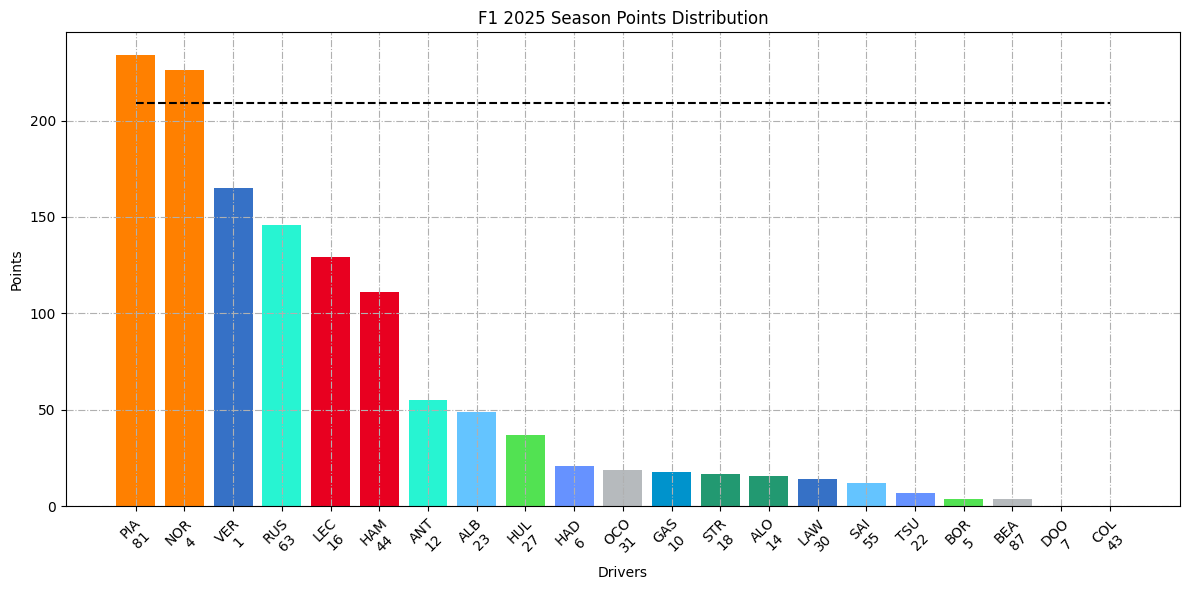

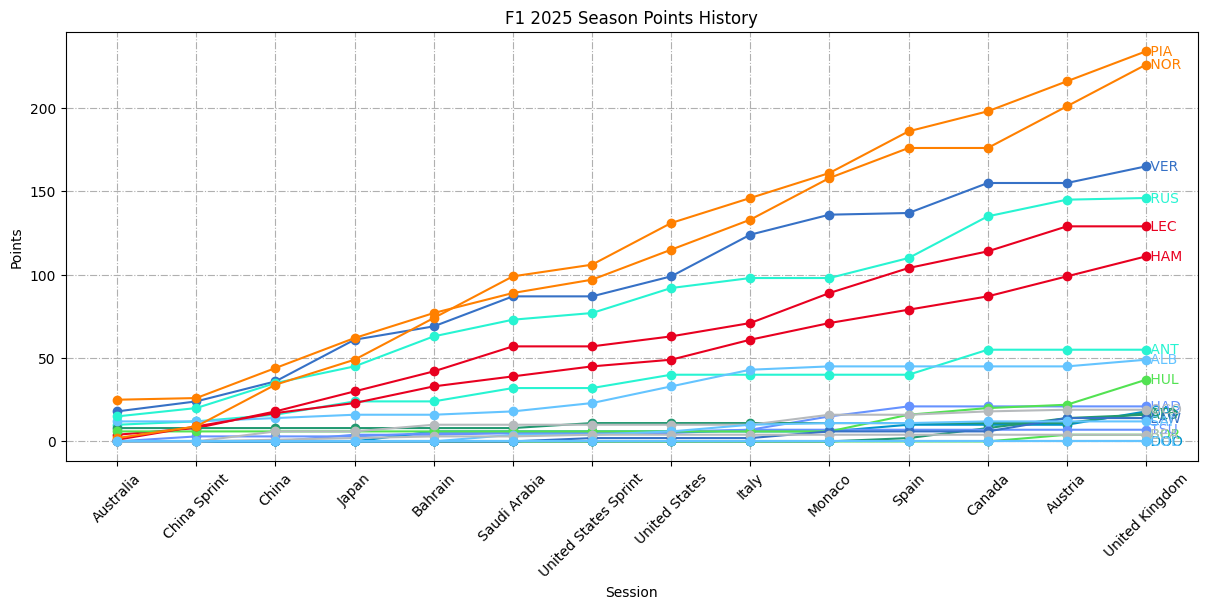

In [8]:
main(year = 2025, summary_printout=False, verbose=False, compact=False)

Fetching all sessions for 2025...
Found 14 race/sprint sessions

Trying to find names for 1 drivers([43])...

Trying to find names for remaining 1 drivers with method 2...


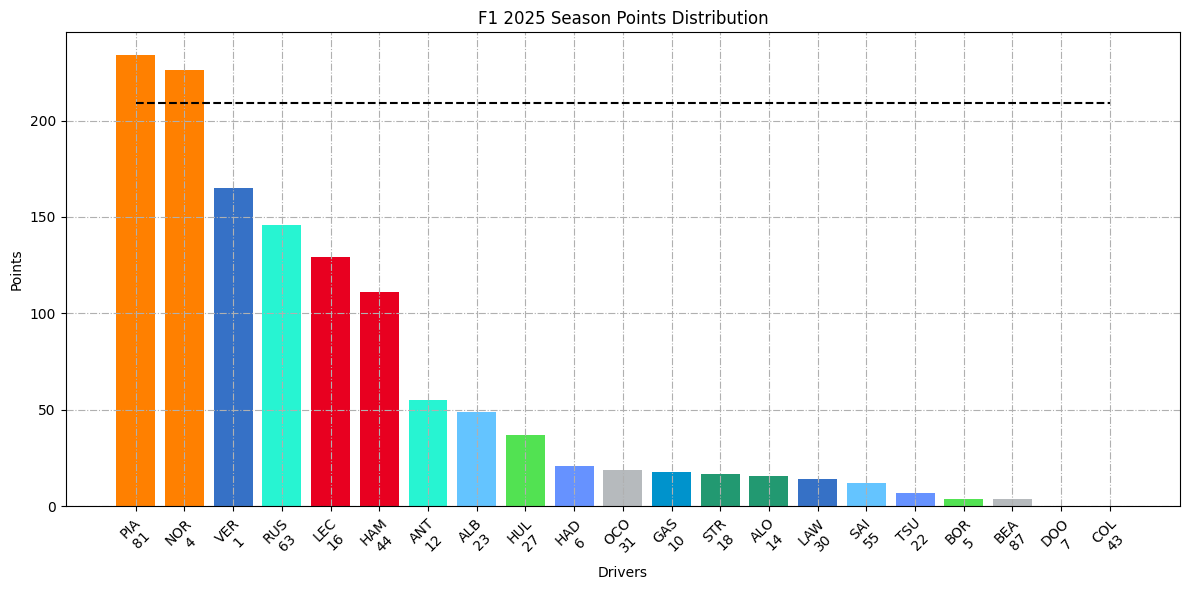

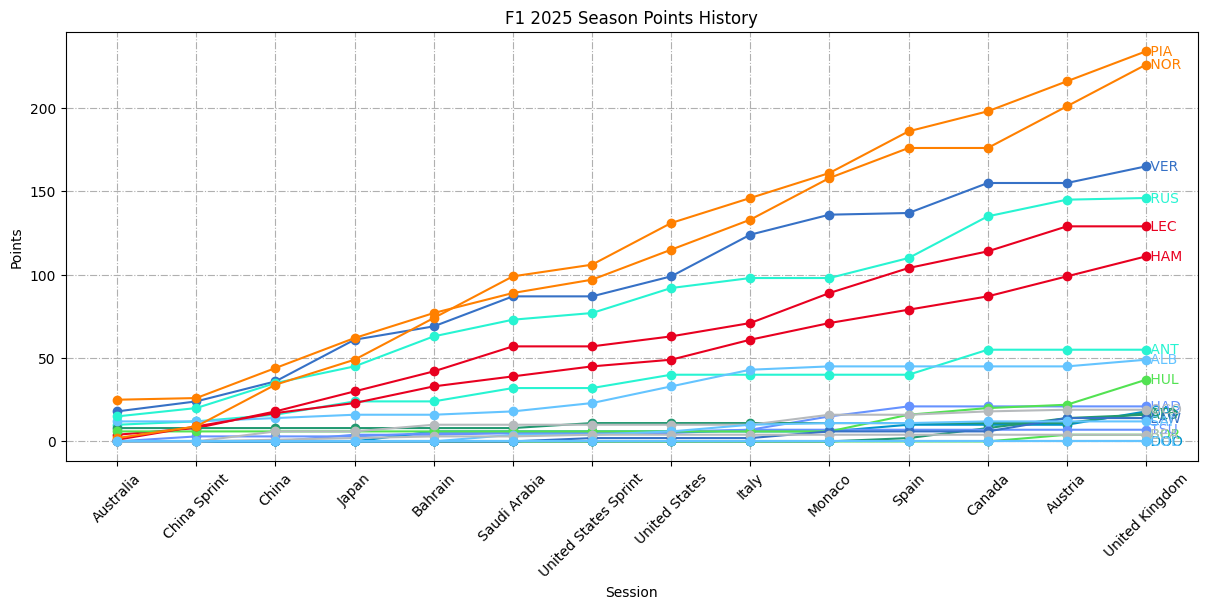

In [9]:
plotting(year = 2025)

Fetching all sessions for 2024...
Found 30 race/sprint sessions

Trying to find names for 5 drivers([38, 43, 50, 30, 61])...

Trying to find names for remaining 5 drivers with method 2...


c:\Users\monca\Desktop\All\Progetti\f1plots\backend\plotGenerator.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(plt_names, rotation=45)
c:\Users\monca\Desktop\All\Progetti\f1plots\backend\plotGenerator.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(session_names, rotation=45)


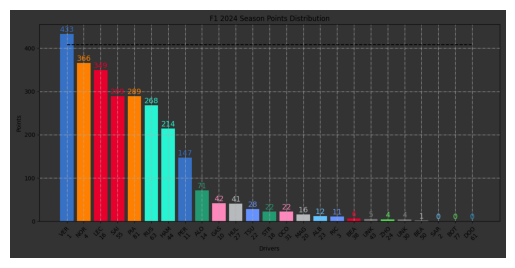

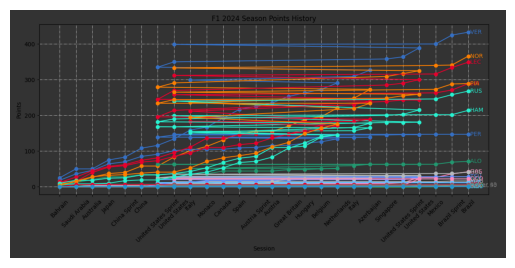

In [18]:
from plotGenerator import generate_plots
import matplotlib.pyplot as plt

def display_image_from_buffer(buf):
    buf.seek(0)  # Reset buffer position to beginning
    img = plt.imread(buf)
    plt.imshow(img)
    plt.axis('off')  # Hide axes if desired
    plt.show()

buf1, buf2 = generate_plots(year = 2024)
display_image_from_buffer(buf1)
display_image_from_buffer(buf2)

In [17]:
buf1.seek(0)  # Reset buffer position to beginning
buf2.seek(0)  # Reset buffer position to beginning

with open("static/plot1_2023.png", 'wb') as f:
        f.write(buf1.read())
with open("static/plot2_2023.png", 'wb') as f:
        f.write(buf2.read())